In [ ]:
# =============================================================================
# PARAMETERS - MODIFY THESE AS NEEDED
# =============================================================================

# Dataset parameters
NUM_SEQUENCES = 10000
SEQUENCE_LENGTH = 800
SEED = 42

# Tokenization parameters
MAX_TOKEN_LENGTH = 40  # Maximum length for padding
PAD_TOKEN = 0
VOCAB_SIZE = 2048  # FAST tokenizer vocabulary size

# Model parameters
D_MODEL = 128
NHEAD = 8
NUM_LAYERS = 4
MAX_SEQ_LEN = 50
CONDITIONING_DIM = 8  # 4 points * 2 (time, value)

# Training parameters
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 32
PATIENCE = 10

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)




# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"📊 Configuration:")
print(f"  - Dataset: {NUM_SEQUENCES:,} sequences, length {SEQUENCE_LENGTH}")
print(f"  - Tokenization: max_length={MAX_TOKEN_LENGTH}, vocab_size={VOCAB_SIZE}")
print(f"  - Model: d_model={D_MODEL}, nhead={NHEAD}, layers={NUM_LAYERS}")
print(f"  - Training: epochs={NUM_EPOCHS}, lr={LEARNING_RATE}, batch_size={BATCH_SIZE}")
print(f"  - Device: {DEVICE}")

# Set up matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Import our modules
from cubic_spline_generator import CubicSplineGenerator
from fast_tokenizer import FASTTokenizer
from transformer_model import SimpleTransformer

print("✅ Setup complete!")

print(f"🔄 Generating dataset with {NUM_SEQUENCES:,} sequences of length {SEQUENCE_LENGTH}...")

# Initialize generator
generator = CubicSplineGenerator(seed=SEED)

# Generate data
times, targets, conditioning = generator.generate_spline_data(
    num_sequences=NUM_SEQUENCES,
    sequence_length=SEQUENCE_LENGTH
)

print(f"✅ Dataset generated successfully!")
print(f"📊 Dataset Statistics:")
print(f"  - Shape: {targets.shape}")
print(f"  - Data range: [{targets.min():.3f}, {targets.max():.3f}]")
print(f"  - Mean: {targets.mean():.3f}, Std: {targets.std():.3f}")
print(f"  - Conditioning shape: {conditioning.shape}")


📊 Configuration:
  - Dataset: 10,000 sequences, length 800
  - Tokenization: max_length=40, vocab_size=1024
  - Model: d_model=128, nhead=8, layers=4
  - Training: epochs=100, lr=0.001, batch_size=32
  - Device: cuda
✅ Setup complete!
🔄 Generating dataset with 10,000 sequences of length 800...
✅ Dataset generated successfully!
📊 Dataset Statistics:
  - Shape: (10000, 800)
  - Data range: [-8.000, 8.000]
  - Mean: -0.845, Std: 3.771
  - Conditioning shape: (10000, 4, 2)


In [ ]:
print("🔧 Fitting FAST tokenizer...")

# Initialize and fit FAST tokenizer
fast_tokenizer = FASTTokenizer()
fast_tokenizer.fit(targets)

print(f"✅ FAST tokenizer fitted successfully!")
print(f"📊 Tokenizer Info:")
print(f"  - Action dimension: {fast_tokenizer.action_dim}")
print(f"  - Time horizon: {fast_tokenizer.time_horizon}")
print(f"  - Normalization: q1={fast_tokenizer._q1:.3f}, q99={fast_tokenizer._q99:.3f}")

🔧 Loading pretrained FAST tokenizer...
Loading pretrained FAST tokenizer (no training)...
Pretrained FAST tokenizer loaded successfully!
Action dimension: 1
Time horizon: 800
✅ Pretrained FAST tokenizer loaded successfully!
📊 Tokenizer Info:
  - Action dimension: 1
  - Time horizon: 800
  - Normalization: q1=-7.541, q99=6.927
  - Note: Using pretrained weights from 'physical-intelligence/fast', no training performed


In [4]:
print("🏗️ Initializing model and training setup...")

# Initialize model
model = SimpleTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    max_seq_len=MAX_SEQ_LEN,
    conditioning_dim=CONDITIONING_DIM
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Model created with {total_params:,} parameters")


# Initialize trainer
from training import FASTTrainer
trainer = FASTTrainer(
    model=model,
    tokenizer=fast_tokenizer,
    device=DEVICE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    vocab_size=VOCAB_SIZE,
    pad_token=PAD_TOKEN
)

print("✅ Training setup complete!")


🏗️ Initializing model and training setup...
✅ Model created with 1,057,408 parameters
✅ Training setup complete!


In [5]:
print("📊 Preparing training data...")

# Prepare data with tokenization and attention masks
train_loader, val_loader = trainer.prepare_data(
    times=times,
    targets=targets,
    conditioning=conditioning,
    train_ratio=0.8
)

print(f"✅ Data prepared successfully!")
print(f"📊 Data Statistics:")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Val batches: {len(val_loader)}")
print(f"  - Batch size: {BATCH_SIZE}")

# Show sample batch info
for batch_tokens, batch_conditioning, batch_attention_mask in train_loader:
    print(f"  - Token shape: {batch_tokens.shape}")
    print(f"  - Conditioning shape: {batch_conditioning.shape}")
    print(f"  - Attention mask shape: {batch_attention_mask.shape}")
    print(f"  - Attention mask ratio (True): {batch_attention_mask.float().mean():.3f}")
    break


📊 Preparing training data...
✅ Data prepared successfully!
📊 Data Statistics:
  - Train batches: 250
  - Val batches: 63
  - Batch size: 32
  - Token shape: torch.Size([32, 45])
  - Conditioning shape: torch.Size([32, 4, 2])
  - Attention mask shape: torch.Size([32, 45])
  - Attention mask ratio (True): 0.361


In [6]:
print("🚀 Starting training...")

# Training history
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

# Training loop
for epoch in range(NUM_EPOCHS):
    # Train epoch
    train_loss = trainer.train_epoch(train_loader)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = trainer.validate(val_loader)
    val_losses.append(val_loss)
    
    # Print progress
    if epoch % 10 == 0 or epoch == NUM_EPOCHS - 1:
        print(f"Epoch {epoch:3d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_fast_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"🛑 Early stopping at epoch {epoch}")
            break

print(f"✅ Training completed!")
print(f"📊 Final Results:")
print(f"  - Best validation loss: {best_val_loss:.4f}")
print(f"  - Final train loss: {train_losses[-1]:.4f}")
print(f"  - Final val loss: {val_losses[-1]:.4f}")
print(f"  - Total epochs: {len(train_losses)}")


🚀 Starting training...


/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1422: indexSelectLargeIndex: block: [78,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1422: indexSelectLargeIndex: block: [78,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1422: indexSelectLargeIndex: block: [78,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1422: indexSelectLargeIndex: block: [78,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1422: indexSelectLargeIndex: block: [78,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1422: indexSelectLargeIndex: block: [78,0,0], thread: [101,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:142

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [7]:
# Load best model
model.load_state_dict(torch.load('best_fast_model.pth'))
model.eval()

print("🔍 Evaluating model on validation set...")

# Evaluate on validation set (need to pass raw data, not data loader)
val_mse = trainer.evaluate_mse(
    times=times,
    targets=targets, 
    conditioning=conditioning
)
print(f"✅ Validation MSE: {val_mse:.6f}")

# Generate predictions for visualization
print("🎯 Generating predictions for visualization...")

# Get a few samples from validation set
val_samples = []
for batch_tokens, batch_conditioning, batch_attention_mask in val_loader:
    val_samples.append((batch_tokens[:3], batch_conditioning[:3], batch_attention_mask[:3]))
    if len(val_samples) >= 1:  # Just take first batch
        break

# Generate predictions
with torch.no_grad():
    predictions = []
    targets = []
    
    for batch_tokens, batch_conditioning, batch_attention_mask in val_samples:
        # Generate sequences using greedy=True (same as binning case study)
        generated_tokens = model.generate(
            conditioning_points=batch_conditioning,
            max_length=MAX_TOKEN_LENGTH,
            greedy=True,  # Deterministic generation using argmax
            device=DEVICE,
            tokenizer=fast_tokenizer
        )
        
        # Convert back to continuous values
        for i in range(generated_tokens.shape[0]):
            # Detokenize generated sequence
            pred_sequence = fast_tokenizer.detokenize_with_padding(
                generated_tokens[i].cpu().numpy(),
                pad_token=PAD_TOKEN
            )
            predictions.append(pred_sequence)
            
            # Get original target
            target_sequence = fast_tokenizer.detokenize_with_padding(
                batch_tokens[i].cpu().numpy(),
                pad_token=PAD_TOKEN
            )
            targets.append(target_sequence)

print(f"✅ Generated {len(predictions)} prediction sequences")
print(f"📊 Prediction Statistics:")
print(f"  - Prediction shape: {predictions[0].shape}")
print(f"  - Target shape: {targets[0].shape}")
print(f"  - Prediction range: [{np.array(predictions).min():.3f}, {np.array(predictions).max():.3f}]")
print(f"  - Target range: [{np.array(targets).min():.3f}, {np.array(targets).max():.3f}]")

🔍 Evaluating model on validation set...


OutOfMemoryError: CUDA out of memory. Tried to allocate 626.00 MiB. GPU 0 has a total capacity of 1.83 GiB of which 568.25 MiB is free. Including non-PyTorch memory, this process has 1.26 GiB memory in use. Of the allocated memory 764.30 MiB is allocated by PyTorch, and 457.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 10. Prediction Visualization


NameError: name 'predictions' is not defined

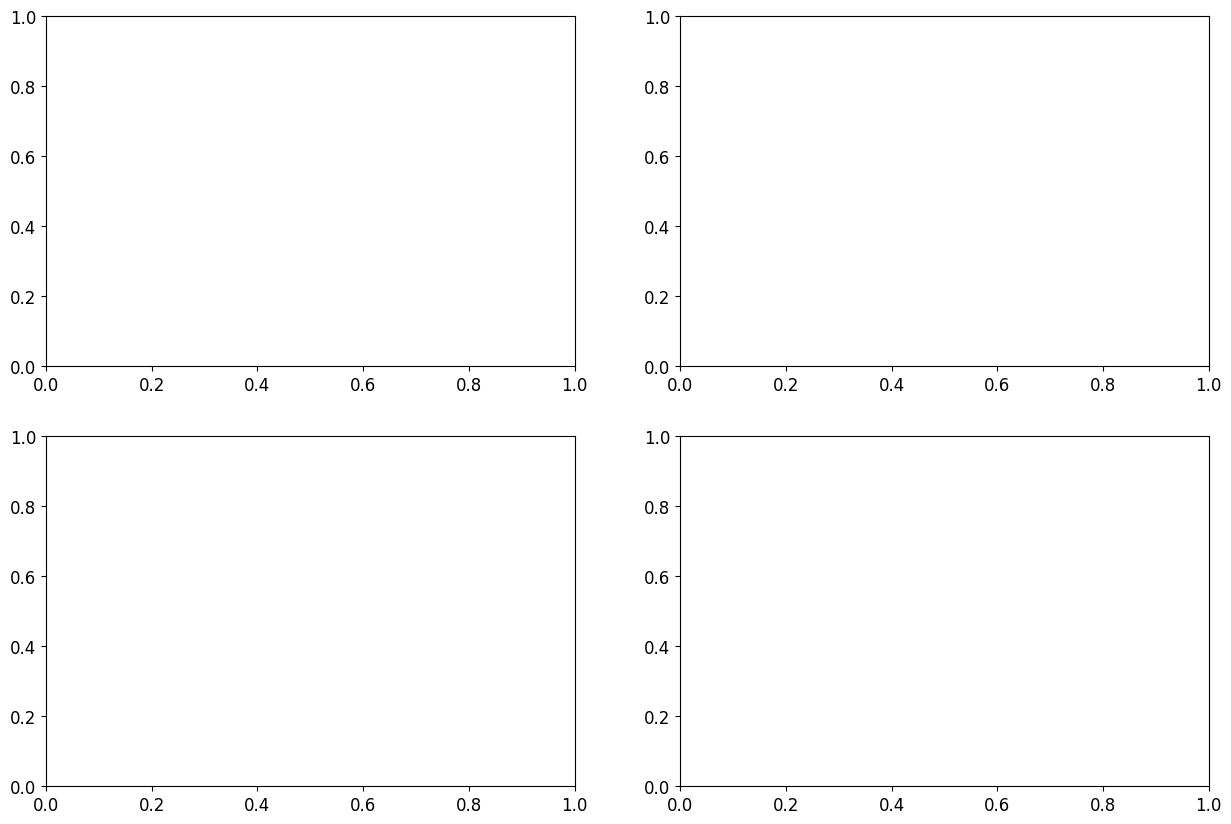

In [10]:
# Visualize predictions vs targets
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(4, len(predictions))):
    ax = axes[i]
    
    # Plot target and prediction
    ax.plot(targets[i], label='Target', alpha=0.8, linewidth=2)
    ax.plot(predictions[i], label='Prediction', alpha=0.8, linewidth=2, linestyle='--')
    
    # Calculate MSE for this sequence
    mse = np.mean((targets[i] - predictions[i])**2)
    
    ax.set_title(f'Sequence {i+1} (MSE: {mse:.4f})')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate overall statistics
all_targets = np.concatenate(targets)
all_predictions = np.concatenate(predictions)
overall_mse = np.mean((all_targets - all_predictions)**2)
overall_mae = np.mean(np.abs(all_targets - all_predictions))

print(f"📊 Overall Prediction Statistics:")
print(f"  - Overall MSE: {overall_mse:.6f}")
print(f"  - Overall MAE: {overall_mae:.6f}")
print(f"  - Correlation: {np.corrcoef(all_targets, all_predictions)[0,1]:.4f}")

# Plot correlation
plt.figure(figsize=(8, 6))
plt.scatter(all_targets, all_predictions, alpha=0.5, s=1)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--', alpha=0.8)
plt.xlabel('Target Values')
plt.ylabel('Predicted Values')
plt.title(f'Target vs Prediction Correlation (r={np.corrcoef(all_targets, all_predictions)[0,1]:.4f})')
plt.grid(True, alpha=0.3)
plt.show()
